In [138]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import gym_minigrid
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from gym_minigrid.envs.doorkey import DoorKeyEnv
from gym.envs.registration import registry, register
import pandas as pd
import random
from tqdm import tqdm
from typing_extensions import Self
import matplotlib.pyplot as plt

In [139]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

print(DEVICE)

class Config:
    """
    Stores algorithmic hyperparameters.
    """
    def __init__(self,
                score_threshold=0.93,
                discount=0.995,
                lr=1e-3,
                max_grad_norm=0.5,
                log_interval=10,
                max_episodes=2000,
                gae_lambda=0.95,
                use_critic=True,
                clip_ratio=0.2,
                target_kl=0.01,
                fit_badly_coeff=0.2,
                train_ac_iters=5,
                use_discounted_reward=False,
                ln_entropy_coef=-4.6,
                use_gae=True,
                my_var=0):

        self.score_threshold = score_threshold # criterion for early stopping. If the rolling average reward (over the last 100 episodes) is greater than it, it ends.
        self.discount = discount # reward discount factor
        self.lr = lr # learning rate
        self.max_grad_norm = max_grad_norm # the maximum gradient norm (https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)
        self.log_interval = log_interval # logging interval
        self.max_episodes = max_episodes # the maximum number of episodes.
        self.use_critic = use_critic # whether to use critic or not.
        self.clip_ratio = clip_ratio # clip_ratio of PPO.
        self.target_kl = target_kl # target KL divergence for early stoping train_ac_iters for PPO
        self.fit_badly_coeff = fit_badly_coeff # the bound of approx. KL of when the model fits badly to the data.
        self.train_ac_iters = train_ac_iters # how many time to train ac_model using current computed old_logps
        self.gae_lambda=gae_lambda # lambda in Generalized Advantage Estimation (GAE)
        self.use_discounted_reward=use_discounted_reward # whether use discounted reward or not.
        self.ln_entropy_coef = ln_entropy_coef # natural log of entropy coefficient for PPO
        self.use_gae = use_gae # whether to use GAE or not.
        self.my_var = my_var # a variable for testing purposes.

cpu


In [140]:
# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

def preprocess_obss(obss, device=None):
    """
    Convert observation into Torch.Tensor

    Parameters
    ----
    obss: dictionary or np.ndarray
    device: target device of torch.Tensor ('cpu', 'cuda')

    Return
    ----
    Torch Tensor
    """
    if isinstance(obss, dict):
        images = np.array([obss["image"]])
    else:
        images = np.array([o["image"] for o in obss])

    return torch.tensor(images, device=device, dtype=torch.float)

class DoorKeyEnv5x5(DoorKeyEnv):
    def __init__(self):
        self.render_mode = "rgb_array"
        super().__init__(size=5)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1
    
class DoorKeyEnv6x6(DoorKeyEnv):
    def __init__(self):
        self.render_mode = "rgb_array"
        super().__init__(size=6)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1
    
class DoorKeyEnv8x8(DoorKeyEnv):
    def __init__(self):
        self.render_mode = "rgb_array"
        super().__init__(size=8)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

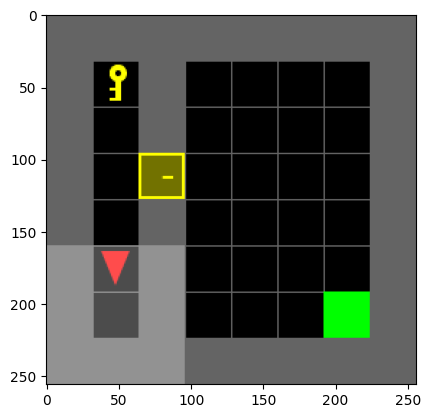

In [141]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

env = DoorKeyEnv8x8() # define environment.
env.reset(seed = 42)
action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(action)

# get an RGB image corresponding to the whole environment or the agent's point of view (https://github.com/Farama-Foundation/Minigrid/blob/master/minigrid/minigrid_env.py#L716)
#            highlight (bool): If true, the agent's field of view or point of view is highlighted with a lighter gray color.
#            tile_size (int): How many pixels will form a tile from the NxM grid.
#            agent_pov (bool): If true, the rendered frame will only contain the point of view of the agent.
frame = env.get_frame(highlight=env.highlight, tile_size=env.tile_size, agent_pov=env.agent_pov)
# show an image to the notebook.
plt.imshow(frame)

In [142]:
class ACModel(nn.Module):
    def __init__(self, num_actions, use_critic=True):
        """
        Represents an Actor Crictic model that takes a 2d, multi-channeled
        image as input.

        Parameters
        ----
        num_actions : int

                      The action space of the environment.
                      The action space for DoorKey5x5 is 7-dimensional:
                      0: turn left,
                      1: turn right,
                      2: forward,
                      3: pickup an object,
                      4: drop an object,
                      5: activate an object,
                      6: done completing task

        use_critics : bool

                      Critic network will be used in forward pass if flag is set
                      to true.
        """
        super().__init__()
        self.use_critic = use_critic

        # Define actor's model
        self.image_conv_actor = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, num_actions)
        )

        # Define critic's model
        if self.use_critic:
            self.image_conv_critic = nn.Sequential(
                nn.Conv2d(3, 16, (2, 2)),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(16, 32, (2, 2)),
                nn.ReLU(),
                nn.Conv2d(32, 64, (2, 2)),
                nn.ReLU()
            )
            self.critic = nn.Sequential(
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, 1)
            )

        # Initialize parameters correctly
        self.apply(init_params)

    def forward(self, obs):
        """
        Performs a forward pass through the actor-critic network

        Parameters
        ----
        obs : int tensor. Shape [Batch size, ImWidth, ImHeight, Channels]

              input to the network.
        ----

        returns:

        dist : torch.distribution
            The distribution of actions from policy. A Categorical distribution
            for discreet action spaces.
        value : torch.Tensor (Batch size, 1)
            value output by critic network
        """
        conv_in = obs.transpose(1, 3).transpose(2, 3) # reshape into [b, c, h, w]

        dist, value = None, None

        x = self.image_conv_actor(conv_in)
        embedding = x.reshape(x.shape[0], -1)

        x = self.actor(embedding)
        dist = Categorical(logits=F.log_softmax(x, dim=1))

        if self.use_critic:
            y = self.image_conv_critic(conv_in)
            embedding = y.reshape(y.shape[0], -1)

            value = self.critic(embedding).squeeze(1)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)
        
        return dist, value

def compute_discounted_return(rewards, discount, device=DEVICE):
    """
		rewards: reward obtained at timestep.  Shape: (T,)
		discount: discount factor. float

    ----
    returns: sum of discounted rewards. Shape: (T,)
		"""
    returns = torch.zeros(*rewards.shape, device=device)

    R = 0
    for t in reversed(range((rewards.shape[0]))):
        R = rewards[t] + discount * R
        returns[t] = R
    return returns

def compute_advantage_gae(values, rewards, T, gae_lambda, discount):
    """
    Compute Adavantage with GAE. See Section 4.4.2 in the lecture notes.

    values: value at each timestep (T,)
    rewards: reward obtained at each timestep.  Shape: (T,)
    T: the number of frames, float
    gae_lambda: hyperparameter, float
    discount: discount factor, float

    -----

    returns:

    advantages : tensor.float. Shape [T,]

                 gae advantage term for timesteps 0 to T

    """
    advantages = torch.zeros_like(values)
    for i in reversed(range(T)):
        next_value = values[i+1]
        next_advantage = advantages[i+1]

        delta = rewards[i] + discount * next_value  - values[i]
        advantages[i] = delta + discount * gae_lambda * next_advantage
    return advantages[:T]

def check_privilege(performances:list[float], indices:list[int], edge:float) -> bool:
    """
    Check whether the elite indices have privilege over the rest of the population.

    Input:
    - performances
    - num_survivors
    - edge: the target privilege that elites should have.

    Output:
    - bool
    """
    elite_perf = [performances[i] for i in indices]
    pleb_perf = [performances[i] for i in range(len(performances)) if i not in indices]
    if np.mean(elite_perf) >= np.mean(pleb_perf) + edge or np.mean(pleb_perf) >= 1 - edge:
        return True
    else:
        return False
    
def perturb_hps(old_hps:list[float], elite_indices:list[int]) -> list[float]:
    """
    Input:
    - old_hps: list of old hps
    - elite_indices

    Returns:
    - list of perturbed hps
    """
    elite_hps = [old_hps[i] for i in elite_indices]
    mean = np.mean(elite_hps)
    std = np.std(elite_hps)
    for i in range(len(old_hps)):
        if i not in elite_indices:
            old_hps[i] = np.random.normal(mean, std)
    return old_hps 

def smooth_update(L:list[float], window_size:int):
    if len(L) < window_size:
        return np.mean(L)
    else:
        return np.mean(L[-window_size:])

In [143]:
class Machine:
    def __init__(self, num_actions=7, args=Config()):
        """
        A Machine object consists of a ACModel, its hyperparameters, and its history of rewards.

        Args:
            num_actions: size of action space
            args: Model hyperparameters
        """
        self.args = args
        self.model = ACModel(num_actions, use_critic=self.args.use_critic).to(DEVICE)
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)
        self.rewards = []
        self.smooth_rewards = []

    def copy_machine(self, other: Self) -> None:
        """
        Copy state dict from 'other'.
        """
        state_dict = other.model.state_dict()
        for key, v in state_dict.items():
            self.model.state_dict()[key].copy_(v)

    def collect_experiences(self, env:gym.Env):
        """
        Collects rollouts and computes advantages.

        Returns
        -------
        exps : dict
            Contains actions, rewards, advantages etc as attributes.
            Each attribute, e.g. `exps['reward']` has a shape
            (self.num_frames, ...).
        logs : dict
            Useful stats about the training process, including the average
            reward, policy loss, value loss, etc.
        """
        acmodel = self.model

        MAX_FRAMES_PER_EP = 300 # TODO: change this with different environments
        shape = (MAX_FRAMES_PER_EP, )

        actions = torch.zeros(*shape, device=DEVICE, dtype=torch.int)
        values = torch.zeros(*shape, device=DEVICE)
        rewards = torch.zeros(*shape, device=DEVICE)
        log_probs = torch.zeros(*shape, device=DEVICE)
        obss = [None]*MAX_FRAMES_PER_EP

        obs, _ = env.reset()

        total_return = 0

        T = 0

        while True:
            # Do one agent-environment interaction

            preprocessed_obs = preprocess_obss(obs, device=DEVICE)

            with torch.no_grad():
                dist, value = acmodel(preprocessed_obs)

            dist: Categorical
            action = dist.sample()[0]

            obss[T] = obs
            obs, reward, done, _, _ = env.step(action.item())


            # Update experiences values
            actions[T] = action
            values[T] = value
            rewards[T] = reward
            log_probs[T] = dist.log_prob(action)


            total_return += reward
            T += 1

            if done or T>=MAX_FRAMES_PER_EP-1:
                break

        discounted_reward = compute_discounted_return(rewards[:T], self.args.discount, DEVICE)
        exps = dict(
            obs = preprocess_obss([
                obss[i]
                for i in range(T)
            ], device=DEVICE),
            action = actions[:T],
            value  = values[:T],
            reward = rewards[:T],
            log_prob = log_probs[:T],
            discounted_reward = discounted_reward,
            T = T
        )

        logs = {
            "return_per_episode": total_return,
            "num_frames": T
        }

        return exps, logs

    def _compute_policy_loss_ppo(self, obs, init_logp, old_logp, actions, advantages):
        """
        Computes the policy loss for PPO.

        obs: observation to pass into acmodel. shape: (T,)
        init_logp: log probabilities we get from the agent performing the action. shape: (T,)
        old_logp: log probabilities from previous timestep. shape: (T,)
        actions: action at this timestep. shape: (T,ImWidth,ImHeight,Channels)
        advantages: the computed advantages. shape: (T,)

        ---
        Returns:

        policy_loss: ppo policy loss as shown in line 6 of PPO alg. tensor.float. Shape (,1)
        fit_badly: how badly init_logp and old_logp disagrees. tensor.float. Shape (,1)
        approx_kl: an approximation of kl divergence between old_logp and new_logp. tensor.float. Shape (,1)
        """
        policy_loss, approx_kl = 0, 0
        dist, _ = self.model(obs)
        dist: Categorical

        entropy = dist.entropy()
        logps = dist.log_prob(actions)
        r_terms = torch.exp(logps - old_logp)
        ppo_loss = torch.min(r_terms * advantages, torch.clamp(r_terms, 1 - self.args.clip_ratio, 1 + self.args.clip_ratio) * advantages)
        
        # Importance sampling factor
        factors = torch.exp(old_logp - init_logp)
        
        indices = factors < 100

        policy_loss_tensor = factors * ppo_loss + np.exp(self.args.ln_entropy_coef) * entropy
        policy_loss = - torch.mean(policy_loss_tensor[indices])

        # approx_kl = torch.sum(torch.exp(old_logp) * (old_logp - logps)) / torch.sum(torch.exp(old_logp))
        approx_kl = torch.mean((old_logp - logps) ** 2) / 2
        fit_badly = torch.mean((torch.exp(old_logp - init_logp) > 2).float())

        return policy_loss, fit_badly, approx_kl
    
    def _compute_value_loss(self, obs, returns):
        _, value = self.model(obs)
        value_loss = torch.mean((value - returns) ** 2)
        return value_loss

In [144]:
class ReplayBuffer:
    def __init__(self, capacity:int):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, data):
        if len(self.buffer) < self.capacity:
            self.buffer.insert(self.position, data)
        else:
            self.buffer[self.position] = data
        self.position = (self.position + 1) % self.capacity

    def delete(self, index):
        assert index < len(self.buffer)
        del self.buffer[index]
        if index < self.position:
            self.position -= 1

    def sample(self):
        """
        Returns a random sample, and its index.
        """
        i = random.randint(0, len(self.buffer)-1)
        return self.buffer[i], i

    def __len__(self):
        return len(self.buffer)

In [145]:
class MachineCluster:
    def __init__(self, hps, num_machines:int, num_explorers:int, num_survivors:int):
        """
        hps: A dictionary of hyperparameters to optimize, {"hp_name": (low, high)}. The set of keys must be a subset of keys in Machine.args.
        num_machines: The number of machines (things that we train) in the cluster.
        num_explorers: The number of explorers in the cluster.
        num_survivors: The number of survivors to select from the cluster.
        """
        self.num_machines = num_machines
        self.num_explorers = num_explorers
        self.num_survivors = num_survivors
        self.hps = hps
        self.machines = []
        self.explorers = []
        self.success_buffer = ReplayBuffer(capacity = 10)
        self.failure_buffer = ReplayBuffer(capacity = 100)

        for _ in range(self.num_explorers):
            self.explorers.append(Machine(num_actions=7, args=Config(ln_entropy_coef=-3.5)))
        for _ in range(self.num_machines):
            self.machines.append(Machine(num_actions=7, args=Config()))
        
        # Initialize hyperparameters
        # TODO: change this?
        for hp in self.hps.keys():
            values = np.random.uniform(self.hps[hp][0], self.hps[hp][1], self.num_machines)
            self.update_hp(hp, values)

    def update_hp(self, hp:str, targets:list[float]) -> None:
        """
        Update the hyperparameters of the models in the cluster.

        Args:
            hp: The hyperparameter to update.
            targets: The target hyperparameter values. Has length self.num_models.
        """
        for i in range(self.num_machines):
            setattr(self.machines[i].args, hp, targets[i])

    def get_hps(self, hp:str) -> list[float]:
        """
        Get the hyperparameters of the models in the cluster.

        Args:
        - hp: str, element of self.hps.keys().

        Returns:
        - ooooo: A list of hp of each model.
        """
        ooooo = [getattr(self.machines[i].args, hp) for i in range(self.num_machines)]
        return ooooo
    
    def explore(self) -> int:
        """
        Use explorers to find success / failure cases.
        """

        epochs = 0

        while len(self.success_buffer) < 1:
            epochs += 1
            i = np.random.randint(self.num_explorers)
            exps, _ = self.explorers[i].collect_experiences(env)
            if exps["reward"][-1] > 0.5:
                self.success_buffer.push(exps)
            elif len(self.failure_buffer) < 100:
                self.failure_buffer.push(exps)
        #     for machine in self.machines:
        #         _, reward_exps = machine.collect_experiences(env)
        #         machine.rewards.append(reward_exps['return_per_episode'])
        #         machine.smooth_rewards.append(smooth_update(machine.rewards, 100))
        
        # print(len(self.machines[0].smooth_rewards))
        # print(len(self.machines[1].smooth_rewards))

        return epochs
    
    def generate_data(self):
        """
        Generate data for training the models.

        Return:
            exps: shape defined in collect_experiences.
            i: index in the replay buffer, or None.
        """

        i = np.random.randint(self.num_machines)
        exps, _ = self.machines[i].collect_experiences(env)
        if exps["reward"][-1] > 0.5:
            self.success_buffer.push(exps)
            print(f"Machine {i} got reward. Current lengths: {len(self.success_buffer)}, {len(self.failure_buffer)}")
            return exps, self.success_buffer.position - 1
        else:
            self.failure_buffer.push(exps)
            print(f"Machine {i} got no reward. Current lengths: {len(self.success_buffer)}, {len(self.failure_buffer)}")
            if len(self.success_buffer) > 0:
                if np.random.random() < 0.75:
                    return self.success_buffer.sample()
                else:
                    return self.failure_buffer.sample()
            else:
                return exps, None
    
    def train_one_step(self, exps):
        """
        Do at most self.args.train_ac_iters step of optimization on each model in the cluster, using exps.

        Args:
            exps: shape defined in collect_experiences.

        Return:
            logs: dict {"fit_badly_ratio": float, "shit": np.array of shape (self.num_machines, 1, 4)}. The last dimension stand for policy_loss, value_loss, fit_badly, approx_kl.
        """
        MAX_FRAMES_PER_EP = 300
        logs = {"fit_badly_ratio": None, "shit": np.empty((self.num_machines, 1, 4), dtype=float)}
        fit_badly_count = 0
        steps_count = 0

        T = exps['T']
        obs = exps['obs']
        init_logp = exps['log_prob']
        full_reward = torch.cat([exps['reward'], torch.zeros((MAX_FRAMES_PER_EP - len(exps['reward']), ), device=DEVICE)], dim=0)
        
        for machine_idx in range(self.num_machines):
            machine = self.machines[machine_idx]

            dist, values = machine.model(obs)
            old_logp = dist.log_prob(exps['action']).detach()

            # add 0 to end of values until it has length MAX_FRAMES_PER_EP
            values_extended = torch.cat([values, torch.zeros((MAX_FRAMES_PER_EP - len(values), ), device=DEVICE)], dim=0)

            # compute advantage
            if machine.args.use_gae:
                advantage = compute_advantage_gae(values_extended.detach(), full_reward, T, machine.args.gae_lambda, machine.args.discount)
            else:
                advantage = exps['discounted_reward'] - values.reshape(-1)
            
            # log data
            policy_loss, fit_badly, approx_kl = machine._compute_policy_loss_ppo(obs, init_logp, old_logp, exps['action'], advantage)
            value_loss = machine._compute_value_loss(obs, exps['discounted_reward'])
            logs["shit"][machine_idx, 0, :] = [float(policy_loss.item()), float(value_loss.item()), float(fit_badly.item()), float(approx_kl.item())]

            policy_loss, value_loss, fit_badly, approx_kl = 0, 0, 0, 0

            for ac_iter in range(machine.args.train_ac_iters):  
                machine.optim.zero_grad()
                
                # compute policy and value loss
                policy_loss, fit_badly, approx_kl = machine._compute_policy_loss_ppo(obs, init_logp, old_logp, exps['action'], advantage)
                value_loss = machine._compute_value_loss(obs, exps['discounted_reward'])

                if approx_kl > 1.5 * machine.args.target_kl:
                    break
                if ac_iter == 0:
                    steps_count += 1
                if fit_badly > machine.args.fit_badly_coeff:
                    fit_badly_count += 1
                    break
                
                loss = policy_loss + value_loss
                loss.backward(retain_graph = True)
                machine.optim.step()
                
                # print(f"Machine {machine_idx} on ac_iter {ac_iter}:", [float(policy_loss.item()), float(value_loss.item()), float(fit_badly.item()), approx_kl.item()])

            # collect experiences and compute rewards
            _, exp = machine.collect_experiences(env)
            machine.rewards.append(exp['return_per_episode'])
            machine.smooth_rewards.append(smooth_update(machine.rewards, 100))
        
        assert steps_count != 0
        fit_badly_ratio = fit_badly_count / steps_count
        logs["fit_badly_ratio"] = fit_badly_ratio
        
        return logs

    def train(self, max_steps):
        """
        Train each model in the cluster until data fits poorly, or until reaches max_steps.

        Return:
        logs: dict {"fit_badly_ratio": [L], "shit": np.array of shape (self.num_machines, L, 4)}. The last dimension stand for policy_loss, value_loss, fit_badly, approx_kl.
        steps: int
        """ 

        logs = {"fit_badly_ratio": [], "shit": None}
        steps = 0
    
        while steps < max_steps:
            exps, idx = self.generate_data()
            # print("experience index:", idx)
            new_logs = self.train_one_step(exps)

            new_fit_badly_ratio = new_logs["fit_badly_ratio"]
            logs["fit_badly_ratio"].append(new_fit_badly_ratio)

            print(f"Step {steps} fit badly ratio: {new_fit_badly_ratio}")

            if logs["shit"] is None:
                logs["shit"] = new_logs["shit"]
            else:
                logs["shit"] = np.concatenate((logs["shit"], new_logs["shit"]), axis=1)

            steps += 1
            if steps >= 10:
                if np.mean(np.array(logs["fit_badly_ratio"][-10:]) > 0.5) > 0.5:
                    break
            
            if idx is None:
                break

            if new_fit_badly_ratio > 0.75:
                if exps["reward"][-1] > 0.5:
                    print("before", len(self.success_buffer))
                    self.success_buffer.delete(idx)
                    print("after", len(self.success_buffer))
                else:
                    self.failure_buffer.delete(idx)
                    # print(len(self.failure_buffer))
        
        print(f"This iteration took {steps} epochs")
        return logs, steps
        
    def evaluate(self, num_trials:int) -> list[float]:
        """
        Evaluate the performance of the models in the cluster.

        Args:
        - trained_models: list of Machines.
        - num_trials: the number of trials to evaluate the models.

        Returns:
        - performances: list of floats. The average return of each model.
        """

        performances = []

        for machine in self.machines:
            avg_reward = 0
            for i in range(num_trials):
                _, logs = machine.collect_experiences(env)
                avg_reward += logs['return_per_episode']
            performances.append(avg_reward / num_trials)

        return performances
        
    def reproduce(self, performances, indices) -> None:
        """
        Select and reproduce the survivors.
        """

        # TODO: use smooth rewards?
        
        probs = torch.tensor([performances[x] if x in indices else 0 for x in range(self.num_machines)])
        dist = torch.distributions.Categorical(probs=probs)

        for i in range(self.num_machines):
            if i not in indices:
                self.machines[i].copy_machine(self.machines[dist.sample().item()])
        
        for j in range(self.num_explorers):
            self.explorers[j].copy_machine(self.machines[dist.sample().item()])
    
    def shift_hps(self, indices):
        """
        Shift hyperparameters.
        TODO: Shift explorer hyperparams too?
        """

        for hp in self.hps.keys():
            old_hps = self.get_hps(hp)
            print("Old hps:", old_hps)
            new_hps = perturb_hps(old_hps, indices)
            print("New hps:", new_hps)
            self.update_hp(hp, new_hps)

In [146]:
def run_cluster_experiment(hps:dict[str, tuple[float, float]],
                           num_machines:int=5, 
                           num_explorers:int=20,
                           num_survivors:int=3,
                           num_iters:int=100,
                           num_trials:int=20,
                           max_steps:int=50, 
                           seed=42):
    """
    Run the cluster experiment.

    Returns:
    - logs: dict {"fit_badly_ratio": list, 
                  "shit": np.array, 
                  "rewards": list of length num_machines, 
                  "smooth_rewards": list of length num_machines}
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    logs = {"fit_badly_ratio": [], "shit": None}
    cluster = MachineCluster(hps = hps, num_machines = num_machines, num_explorers=num_explorers, num_survivors = num_survivors)
    epochs = 0

    pbar = tqdm(range(num_iters))

    for iter in pbar:
        print(f'Starting iteration {iter}...')

        explore_steps = cluster.explore()
        epochs += explore_steps

        new_logs, new_steps = cluster.train(max_steps=max_steps)
        epochs += new_steps

        logs["fit_badly_ratio"] += new_logs["fit_badly_ratio"]
        
        if logs["shit"] is None:
            logs["shit"] = new_logs["shit"]
        else:
            logs["shit"] = np.concatenate((logs["shit"], new_logs["shit"]), axis=1)

        performances = cluster.evaluate(num_trials=num_trials)
        indices = torch.topk(torch.tensor(performances, device=DEVICE), num_survivors).indices

        if check_privilege(performances, indices, edge=0.02):
            cluster.reproduce(performances, indices)

        if check_privilege(performances, indices, edge=0.1):
            cluster.shift_hps(indices)
        else:
            print("Did not shift hps due to lack of privilege")

        print(f'Iteration {iter} done! Number of epochs so far: {epochs}. Performances: {performances}')

        if np.mean([cluster.machines[i].smooth_rewards[-1] for i in range(num_machines)]) >= 0.93:
            print(f"Done! Total epochs: {epochs}, Total iterations: {iter + 1}" )
            break
    
    logs["rewards"] = [cluster.machines[i].rewards for i in range(num_machines)]
    logs["smooth_rewards"] = [cluster.machines[i].smooth_rewards for i in range(num_machines)]

    return logs, cluster.machines

In [ ]:
logs, trained_machines = run_cluster_experiment(hps={'ln_entropy_coef': (-5.5, -3.5)})

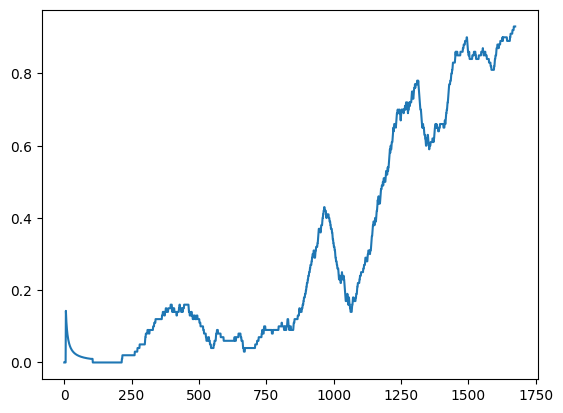

In [151]:
plt.plot(logs["smooth_rewards"][0])

In [ ]:
import math

tests = {}

for i in [50, 20, 10]:
    for j in [2]:
        print(f"Running experiment with {i} explorers and {j} machines...")
        logs, _ = run_cluster_experiment(hps={'ln_entropy_coef': (-5.5, -3.5)},
                                                num_machines = j,
                                                num_survivors = math.ceil(j/2),
                                                num_explorers = i)
        tests[f"({i},{j})"] = logs["smooth_rewards"]
        print(f"Experiment with {i} explorers and {j} machines done!")

In [14]:
%matplotlib inline

import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib.axes import Axes
from matplotlib import rc
import random
from torch import nn
from gym.envs.registration import registry, register
from tqdm.notebook import tqdm
import time

np.bool = np.bool_

rc('animation', html='jshtml')

In [4]:
class Stopwatch:
    def __init__(self, default_time):
        """
        A stopwatch to count down a variable
        """

        # check default_time is a non-negative integer
        assert isinstance(default_time, int) and default_time >= 0, f"Max time {default_time} must be a non-negative integer."

        self.DEFAULT = default_time
        self.current = 0

    def activate(self, time=None):
        """
        Set the time to time or the maximum time if time is None.

        Args:
            time: int or None
        """

        if time is None:
            self.current = self.DEFAULT
        else:
            # check time is a non-negative integer
            assert isinstance(time, int) and time >= 0, f"Time {time} must be a non-negative integer."
            
            self.current = time

    def count_down(self) -> bool:
        """
        Count down the stopwatch by 1.

        Returns:
            False if the stopwatch has reached 0, True otherwise
        """

        if self.current > 0:
            self.current -= 1
            return True
        else:
            return False
        
    def is_on(self) -> bool:
        """
        Check if the stopwatch is on.

        Returns:
            True if the stopwatch is on, False otherwise
        """

        return self.current > 0

    def deactivate(self):
        self.current = 0

class ContinuousBanditV3:
    """
    Action space: R^1
    Objective: maxiamize the expected reward
    """

    def __init__(self,
                 lb=-float('inf'), 
                 ub=float('inf'), 
                 mean=None, 
                 std=None, 
                 min_std=0,
                 max_std=None,
                 sample_number=20, 
                 alpha=0.1,
                 lr=None,
                 mean_lr=0.1,
                 std_lr=0.03,
                 reward_std_lr=0.1,
                 reincarnation=50,
                 restart_pos=None,
                 restart_lr=0.1,
                 database_capacity=100):
        """
        lb: lower bound of action space
        ub: upper bound of action space
        mean: initial mean of the normal distribution
        std: initial standard deviation of the normal distribution
        min_std: minimum standard deviation allowed
        max_std: maximum standard deviation allowed
        sample_number: the number of actions to sample for each pull
        alpha: the parameter for UCB computation
        lr: the learning rate for mean and std (and reward_std)
        mean_lr: the learning rate for mean
        std_lr: the learning rate for std
        reward_std_lr: the learning rate for reward_std
        reincarnation: the period of reincarnation
        restart_pos: the position to restart the mean
        database_capacity: the capacity of the database to store the historical data
        """

        self.lb = lb
        self.ub = ub
        self.can_use_bounds = (lb != -float('inf') and ub != float('inf'))

        if mean is not None:
            self.mean = mean
        elif self.can_use_bounds:
            self.mean = (self.ub + self.lb) / 2
        elif lb != -float('inf'):
            self.mean = self.lb + 1.0
        elif ub != float('inf'):
            self.mean = self.ub - 1.0
        else:
            self.mean = 0.0
        if std is not None:
            self.std = std
        elif lb != -float('inf') and ub != float('inf'):
            self.std = (self.ub - self.lb) / np.sqrt(12)
        else:
            self.std = 1.0

        if max_std is not None:
            self.max_std = max_std
        elif self.can_use_bounds:
            self.max_std = (self.ub - self.lb) / 2
        else:
            self.max_std = float('inf')
        
        self.min_std = min_std
        self.sample_number = sample_number
        self.alpha = alpha
        # self.epsilon = epsilon
        self.database = self.DataBase(capacity=database_capacity) # to store the historical data
        self.reward_std = 1.0 # to store the std of the reward distribution
        if lr is not None:
            self.mean_lr = lr
            self.std_lr = lr
            self.reward_std_lr = lr
        else:
            self.mean_lr = mean_lr
            self.std_lr = std_lr
            self.reward_std_lr = reward_std_lr

        self.STD_FACTOR = np.sqrt(np.pi / 2)

        self.n = 0 # number of times we pull the arm
        self.previous_a = None # to store the previous action

        # these are the memory to draw diagram
        self.col_means = []
        self.col_as = []
        self.col_rs = []
        self.col_std = []

        self.reincarnation = reincarnation
        self.restart_lr = restart_lr
        if restart_pos is not None:
            self.restart_pos = restart_pos
        else:
            self.restart_pos = self.mean


    class DataBase:
        """
        A database to store the historical data of the one-armed bandit problem.
        Data consists of a list of tuples (action, reward)
        """
        
        def __init__(self, capacity: int=100):
            self.data = []
            self.capacity = capacity
            self.bests = [] # store best (a, r, t)'s
            self.protection = Stopwatch(default_time=5) # to protect the bests from being removed too frequently

        def get_length(self) -> int:
            return len(self.data)

        def add_data(self, action: float, reward: float, time_step: int) -> None:
            self.data.append((action, reward, time_step))
            self.bests.append((action, reward, time_step))
            # if exceed capacity, remove the oldest data
            if self.get_length() > self.capacity:
                assert self.get_length() == self.capacity + 1, f'#data = {self.get_length()} > 1 + capacity = {1 + self.capacity}'
                self.data.pop(0)
                # delete the worst reward from bests
                self.bests = sorted(self.bests, key=lambda x: x[1])
                self.bests.pop(0)
            else:
                pass

        def get_data(self) -> list:
            return self.data
        
        def sample_data(self, size: int) -> list:
            return np.random.choice(self.data, size=size)
        
        def fill_bests(self) -> None:
            """
            If bests is not full, fill it with highest current data
            """
            length_bests = len(self.bests)
            assert length_bests <= self.capacity, f'#bests {length_bests} > capacity {self.capacity}.'

            if length_bests < self.capacity:
                num_to_fill = self.capacity - len(self.bests)
                # take num_to_fill bests from data
                best_data = sorted(self.data, key=lambda x: x[1], reverse=True)[:num_to_fill]
                self.bests.extend(best_data)
        
        def compute_std(self, std: float) -> tuple[int, float]:
            """
            Compute std of rewards according to the bests

            Args:
                std: the std of the policy

            Returns:
                mode: 0 for normal
                        1 for need adjustment
                        2 for too small database
                std: the std of the reward distribution
                        if mode = 1, then is the target std to adjust self.std above
            """
            def helper_radius(A: list[float], b: float, are_sort=True) -> float:
                """
                Compute min(abs(a - b)) for a in A

                Args:
                    A: a list of floats
                    b: a float
                    are_sort: if True, A is sorted in ascending order
                
                Returns:
                    min(abs(a - b)) for a in A
                """
                if not are_sort:
                    A = sorted(A)

                low = 0
                high = len(A) - 1
                if A[low] > b:
                    return A[low] - b  
                elif A[high] < b:
                    return b - A[high]
                
                while low < high - 1:
                    mid = (low + high) // 2
                    if A[mid] < b:
                        low = mid
                    else:
                        high = mid

                radius = min(A[high] - b, b - A[low])
                assert radius >= 0, f'radius = {radius} < 0'
                
                return radius

            def helper_min_radius(A: list[float], B: list[float], num_to_fill: int) -> float:
                """
                Compute the minimum radius r such that num_to_fill elements of data from B is within r from A
                """

                # sort A
                A = sorted(A)
                radius_list = []

                for b in B:
                    radius = helper_radius(A, b)
                    radius_list.append(radius)

                # then select the num_to_fill smallest of radius_list
                radius_list = sorted(radius_list)

                return radius_list[num_to_fill - 1]

            if len(self.bests) <= 2:
                return 2, 0.0
            elif self.get_length() < self.capacity:
                return 0, np.std([reward for _, reward, _ in self.bests])
            
            good_data = []

            # take 20 elites from self.bests
            elites = sorted(self.bests, key=lambda x: x[1], reverse=True)[:20]
            elite_as = [a for a, _, _ in elites]
            elite_as = sorted(elite_as)

            for action, reward, t in self.get_data():
                radius = helper_radius(elite_as, action)
                if radius < 2 * std:
                    good_data.append((action, reward, t))

            if len(good_data) >= 10:
                self.protection.count_down()
                return 0, np.std([reward for _, reward, _ in good_data])
            else:
                data_as = [a for a, _, _ in self.get_data()]
                target_std = helper_min_radius(elite_as, data_as, self.get_length() // 2)
                assert target_std >= 2 * std, f'elite_as: {elite_as}\n data_as: {data_as}\n std: {std}\n target_std: {target_std}\n good_data: {good_data}'

                # remove the earliest data in elites from bests
                if not self.protection.is_on():
                    elites = sorted(elites, key=lambda x: x[2])
                    earliest_data = elites[0]
                    self.bests.remove(earliest_data)
                    self.fill_bests()
                
                self.protection.activate()

                return 1, target_std


    def get_mean(self) -> float:
        return self.mean
    
    def get_std(self) -> float:
        return self.std

    def get_sample_number(self) -> int:
        return self.sample_number
    
    def set_sample_number(self, sample_number: int) -> None:
        self.sample_number = sample_number

    def sample_actions(self, size: int) -> np.ndarray[float]:
        """
        sample action according to mean and variance
        args:
            size: the number of actions to sample
        returns:
            actions
        """
        a = np.random.normal(self.mean, self.std, size=size)
        a = np.clip(a, self.lb, self.ub)
        return a
    
    def get_neighbors(self, x: float, k: int) -> list[tuple[float, float, float]]:
        """
        get k nearest neighbors of x in the database
        args:
            x: the query point
            k: the number of neighbors to return
        returns:
            list of length k, each element is a tuple
                    (action, reward, distance)
        """
        distances = [np.abs(x - action) for action, _, _ in self.database.get_data()]
        # if database is too small, return all data
        length_of_database = self.database.get_length()
        if length_of_database < k:
            return [(self.database.get_data()[i][0], self.database.get_data()[i][1], distances[i]) for i in range(length_of_database)]
        
        indices = np.argsort(distances)[:k]
        return [(self.database.get_data()[i][0], self.database.get_data()[i][1], distances[i]) for i in indices]

    def get_ucb(self, a: float) -> float:
        """
        get the upper confidence bound of action a
        args:
            a: the action
        returns:
            the upper confidence bound
        """
        length_of_database = len(self.database.data)
        if length_of_database == 0:
            return float('inf')
        
        neighbors = self.get_neighbors(a, k=10)
        rewards = [reward for _, reward, _ in neighbors]
        value = np.mean(rewards)
        # normalize value
        value /= self.reward_std + 1e-8
        # unexplored = sum(np.log(distance + 1e-8) for _, _, distance in neighbors) / len(neighbors)
        unexplored = -sum(np.sqrt(self.std / (distance + 1e-8)) for _, _, distance in neighbors) / len(neighbors)
        return value + self.alpha * unexplored

    def pull(self) -> float:
        """
        returns:
            best_action
        """
        # sample sample_number actions
        actions = self.sample_actions(self.get_sample_number())
        # get the action with the highest upper confidence bound
        best_action = max(actions, key=self.get_ucb)

        self.previous_a = best_action

        self.n += 1

        return best_action
    
    def update_with_a(self, a: float, reward: float) -> None:
        """
        use (a, reward) to update the mean, std, and database

        args:
            a: the action
            reward: the reward
        """
        def update_mean(target: float) -> None:
            self.mean = (1 - self.mean_lr) * self.mean + self.mean_lr * target
        
        def update_std(target: float) -> None:
            self.std = (1 - self.std_lr) * self.std + self.std_lr * target

        def update_reward_std(target: float) -> None:
            self.reward_std = (1 - self.reward_std_lr) * self.reward_std + self.reward_std_lr * target

        # first of all, append data into collections
        self.col_means.append(self.mean)
        self.col_as.append(a)
        self.col_rs.append(reward)
        self.col_std.append(self.std)

        # add data to database
        self.database.add_data(a, reward, self.n)
        # update reward_std
        mode, std = self.database.compute_std(self.std)
        if mode == 0:
            update_reward_std(std)
        elif mode == 1:
            # increase std
            #print('adjusted')
            update_std(std)
        elif mode == 2:
            pass
        # update mean and std
        update_std(self.STD_FACTOR * np.abs(a - self.mean))
        self.std = np.clip(self.std, self.min_std, self.max_std)
        update_mean(a)

        # do reincarnation
        if self.n % self.reincarnation == 0 and self.n >= 2 * self.reincarnation:
            average_r_before = np.mean(self.col_rs[-2 * self.reincarnation: -self.reincarnation])
            average_r_after = np.mean(self.col_rs[-self.reincarnation:])
            if average_r_after <= average_r_before:
                self.restart()
    
    def update(self, reward: float) -> None:
        """
        use (a, reward) to update the mean, std, and database
        a = self.previous_a

        args:
            reward: the reward
        """
        self.update_with_a(self.previous_a, reward)

    def restart(self) -> None:
        """
        restart the mean to restart_pos
        """
        shift = self.mean - self.restart_pos
        self.mean = self.restart_pos
        # soft update restart_pos
        self.restart_pos += self.restart_lr * shift

    def draw(self, low=0, high=None, draw_mean=True, draw_a=True, draw_r=False, draw_std=False) -> None:
        """
        draw the diagram of the one-armed bandit problem
        """
        import matplotlib.pyplot as plt

        length = len(self.col_means)

        if high is None:
            high = length

        plt.figure()
        x_axis = range(length)
        if draw_mean:
            plt.plot(x_axis[low:high], self.col_means[low:high], label='mean')
        if draw_a:
            plt.plot(x_axis[low:high], self.col_as[low:high], label='a')
        if draw_std:
            plt.plot(x_axis[low:high], self.col_std[low:high], label='std')
        
        plt.legend()
        plt.show()

        if draw_r:
            plt.figure()
            plt.plot(x_axis[low:high], self.col_rs[low:high], label='r')
        

In [5]:
def get_device() -> torch.device:
    """
    Returns the device to use for training.
    """

    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

DEVICE = get_device()

class CartpoleDynamics:
    def __init__(self,
                 timestep=0.02,
                 m_p=0.5,
                 m_c=0.5,
                 l=0.6,
                 g=-9.81,
                 u_range=15):
        """
        Initializes the Cartpole Dynamics model with given parameters.

        Parameters:
        - timestep (float): The time step for the simulation.
        - m_p (float): Mass of the pole.
        - m_c (float): Mass of the cart.
        - l (float): Length of the pole.
        - g (float): Acceleration due to gravity. Negative values indicate direction.
        - u_range (float): Range of the control input.
        """

        self.m_p  = m_p
        self.m_c  = m_c
        self.l    = l
        self.g    = -g
        self.dt   = timestep

        self.u_range = u_range

        self.u_lb = torch.tensor([-1]).float()
        self.u_ub = torch.tensor([1]).float()
        self.q_shape = 4
        self.u_shape = 1

    def _qdotdot(self, q, u):
        """
        Calculates the acceleration of both cart and pole as a function of the current state and control input.

        Parameters:
        - q (torch.Tensor): The current state of the system, [x, theta, xdot, thetadot].
        - u (torch.Tensor): The current control input.

        Returns:
        - torch.Tensor: Accelerations [x_dotdot, theta_dotdot] of the cart and the pole.
        """
        x, theta, xdot, thetadot = q.T

        if len(u.shape) == 2:
            u = torch.flatten(u)

        x_dotdot = (
            u + self.m_p * torch.sin(theta) * (
                self.l * torch.pow(thetadot,2) + self.g * torch.cos(theta)
            )
        ) / (self.m_c + self.m_p * torch.sin(theta)**2)

        theta_dotdot = (
            -u*torch.cos(theta) -
            self.m_p * self.l * torch.pow(thetadot,2) * torch.cos(theta) * torch.sin(theta) -
            (self.m_c + self.m_p) * self.g * torch.sin(theta)
        ) / (self.l * (self.m_c + self.m_p * torch.sin(theta)**2))

        return torch.stack((x_dotdot, theta_dotdot), dim=-1)

    def _euler_int(self, q, qdotdot):
        """
        Performs Euler integration to calculate the new state given the current state and accelerations.

        Parameters:
        - q (torch.Tensor): The current state of the system, [x, theta, xdot, thetadot].
        - qdotdot (torch.Tensor): The accelerations [x_dotdot, theta_dotdot] of the cart and the pole.

        Returns:
        - torch.Tensor: The new state of the system after a single time step.
        """

        qdot_new = q[...,2:] + qdotdot * self.dt
        q_new = q[...,:2] + self.dt * qdot_new

        return torch.cat((q_new, qdot_new), dim=-1)

    def step(self, q, u):
        """
        Performs a single step of simulation given the current state and control input.

        Parameters:
        - q (torch.Tensor or np.ndarray): The current state of the system.
        - u (torch.Tensor or np.ndarray): The current control input.

        Returns:
        - torch.Tensor: The new state of the system after the step.
        """

        # Check for numpy array
        if isinstance(q, np.ndarray):
            q = torch.from_numpy(q)
        if isinstance(u, np.ndarray):
            u = torch.from_numpy(u)

        scaled_u = u * float(self.u_range)

        # Check for shape issues
        if len(q.shape) == 2:
            q_dotdot = self._qdotdot(q, scaled_u)
        elif len(q.shape) == 1:
            q_dotdot = self._qdotdot(q.reshape(1,-1), scaled_u)
        else:
            raise RuntimeError('Invalid q shape')

        new_q = self._euler_int(q, q_dotdot)

        if len(q.shape) == 1:
            new_q = new_q[0]

        return new_q

    # given q [bs, q_shape] and u [bs, t, u_shape] run the trajectories
    def run_batch_of_trajectories(self, q, u):
        """
        Simulates a batch of trajectories given initial states and control inputs over time.

        Parameters:
        - q (torch.Tensor): Initial states for each trajectory in the batch.
        - u (torch.Tensor): Control inputs for each trajectory over time.

        Returns:
        - torch.Tensor: The states of the system at each time step for each trajectory.
        """
        qs = [q]

        for t in range(u.shape[1]):
            qs.append(self.step(qs[-1], u[:,t]))

        return torch.stack(qs, dim=1)

    # given q [bs, t, q_shape] and u [bs, t, u_shape] calculate the rewards
    def reward(self, q, u):
        """
        Calculates the reward for given states and control inputs.

        Parameters:
        - q (torch.Tensor or np.ndarray): States of the system.
        - u (torch.Tensor or np.ndarray): Control inputs applied.

        Returns:
        - torch.Tensor: The calculated rewards for the states and inputs.
        """

        if isinstance(q, np.ndarray):
            q = torch.from_numpy(q)
        if isinstance(u, np.ndarray):
            u = torch.from_numpy(u)

        angle_term = 0.5*(1-torch.cos(q[...,1]))
        pos_term = -0.5*torch.pow(q[...,0],2)
        ctrl_cost = -0.001*(u**2).sum(dim=-1)

        return angle_term + pos_term + ctrl_cost

class CartpoleGym(gym.Env):
    def __init__(self, timestep_limit=200):
        """
        Initializes the Cartpole environment with a specified time step limit.

        Parameters:
        - timestep_limit (int): The maximum number of timesteps for each episode.

        Sets up the dynamics model and initializes the simulation state.
        """
        self.dynamics = CartpoleDynamics()

        self.timestep_limit = timestep_limit
        self.reset()

    def reset(self):
        """
        Resets the environment to the initial state.

        Returns:
        - np.ndarray: The initial state of the environment.
        """

        self.q_sim = np.zeros(4)
        self.timesteps = 0

        self.traj = [self.get_observation()]

        return self.traj[-1]

    def get_observation(self):
        """
        Retrieves the current state of the environment.

        Returns:
        - np.ndarray: The current state of the simulation.
        """

        return self.q_sim

    def step(self, action):
        """
        Executes one time step within the environment using the given action.

        Parameters:
        - action (np.ndarray): The action to apply for this timestep.

        Returns:
        - Tuple[np.ndarray, float, bool, dict]: A tuple containing the new state, the reward received,
          a boolean indicating whether the episode is done, and an info dictionary.
        """
        action = np.clip(action, self.action_space.low, self.action_space.high)[0]

        new_q = self.dynamics.step(
            self.q_sim, action
        )

        if not isinstance(action, torch.Tensor):
            action = torch.tensor(action)

        reward = self.dynamics.reward(
            new_q, action
        ).numpy()

        self.q_sim = new_q.numpy()
        done = self.is_done()

        self.timesteps += 1

        self.traj.append(self.q_sim)

        return self.q_sim, reward, done, {}

    def is_done(self):
        """
        Checks if the episode has finished based on the timestep limit.

        Returns:
        - bool: True if the episode is finished, False otherwise.
        """
        # Kill trial when too much time has passed
        if self.timesteps >= self.timestep_limit:
            return True

        return False

    def plot_func(self, to_plot, i=None):
        """
        Plots the current state of the cartpole system for visualization.

        Parameters:
        - to_plot (matplotlib.axes.Axes or dict): Axes for plotting or a dictionary of plot elements to update.
        - i (int, optional): The index of the current state in the trajectory to plot.
        """
        def _square(center_x, center_y, shape, angle):
            trans_points = np.array([
                [shape[0], shape[1]],
                [-shape[0], shape[1]],
                [-shape[0], -shape[1]],
                [shape[0], -shape[1]],
                [shape[0], shape[1]]
            ]) @ np.array([
                [np.cos(angle), np.sin(angle)],
                [-np.sin(angle), np.cos(angle)]
            ]) + np.array([center_x, center_y])

            return trans_points[:, 0], trans_points[:, 1]

        if isinstance(to_plot, Axes):
            imgs = dict(
                cart=to_plot.plot([], [], c="k")[0],
                pole=to_plot.plot([], [], c="k", linewidth=5)[0],
                center=to_plot.plot([], [], marker="o", c="k",
                                          markersize=10)[0]
            )

            x_width = max(1,max(np.abs(t[0]) for t in self.traj) * 1.3)

            # centerline
            to_plot.plot(np.linspace(-x_width, x_width, num=50), np.zeros(50),
                         c="k", linestyle="dashed")

            # set axis
            to_plot.set_xlim([-x_width, x_width])
            to_plot.set_ylim([-self.dynamics.l*1.2, self.dynamics.l*1.2])

            return imgs

        curr_x = self.traj[i]

        cart_size = (0.15, 0.1)

        cart_x, cart_y = _square(curr_x[0], 0.,
                                cart_size, 0.)

        pole_x = np.array([curr_x[0], curr_x[0] + self.dynamics.l
                           * np.cos(curr_x[1]-np.pi/2)])
        pole_y = np.array([0., self.dynamics.l
                           * np.sin(curr_x[1]-np.pi/2)])

        to_plot["cart"].set_data(cart_x, cart_y)
        to_plot["pole"].set_data(pole_x, pole_y)
        to_plot["center"].set_data(self.traj[i][0], 0.)

    def render(self, mode="human"):
        """
        Renders the current state of the environment using a matplotlib animation.

        This function creates a matplotlib figure and uses the plot_func method to update the figure with the current
        state of the cartpole system at each timestep. The animation is created with the FuncAnimation class and is
        configured to play at a specified frame rate.

        Parameters:
        - mode (str): The mode for rendering. Currently, only "human" mode is supported, which displays the animation
          on screen.

        Returns:
        - matplotlib.animation.FuncAnimation: The animation object that can be displayed in a Jupyter notebook or
          saved to file.
        """
        self.anim_fig = plt.figure()

        self.axis = self.anim_fig.add_subplot(111)
        self.axis.set_aspect('equal', adjustable='box')

        imgs = self.plot_func(self.axis)
        _update_img = lambda i: self.plot_func(imgs, i)

        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

        ani = FuncAnimation(
            self.anim_fig, _update_img, interval=self.dynamics.dt*1000,
            frames=len(self.traj)-1
        )

        plt.close()

        return ani

    @property
    def action_space(self):
        """
        Defines the action space of the environment using a Box space from OpenAI Gym.

        The action space is defined based on the lower and upper bounds for the control input specified in the
        dynamics model. This allows for a continuous range of actions that can be applied to the cartpole system.

        Returns:
        - gym.spaces.Box: The action space as a Box object, with low and high bounds derived from the dynamics model's
          control input bounds.
        """
        return gym.spaces.Box(low=self.dynamics.u_lb.numpy(), high=self.dynamics.u_ub.numpy())

    @property
    def observation_space(self):
        """
        Defines the observation space of the environment using a Box space from OpenAI Gym.

        The observation space is defined with no bounds on the values, representing the position and velocity of the
        cart and the angle and angular velocity of the pole. This space allows for any real-valued vector of
        positions and velocities to be a valid observation in the environment.

        Returns:
        - gym.spaces.Box: The observation space as a Box object, with low and high bounds set to negative and
          positive infinity, respectively, for each dimension of the state vector.
        """
        return gym.spaces.Box(
            low= np.array([-np.inf, -np.inf, -np.inf, -np.inf]),
            high=np.array([np.inf,   np.inf,  np.inf,  np.inf])
        )

env_name = 'CartpoleSwingUp-v0'
if env_name in gym.envs.registry:
    del gym.envs.registry[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:CartpoleGym',
)

In [6]:
env = gym.make('CartpoleSwingUp-v0')

q = env.reset()
done = False
while not done:
    q, r, done, _ = env.step(env.action_space.sample())

env.render()

/opt/homebrew/Caskroom/miniforge/base/envs/leg/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/leg/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/leg/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/opt/homebrew/Caskroom/miniforge/base/e

In [7]:
class MPC:
    def __init__(self,
        model,
        horizon        = 25,
        es_epsilon     = 0.001,
        es_alpha       = 0.1,
        es_generations = 5,
        es_popsize     = 200,
        es_elites      = 40
    ):
        """
        Initializes the Model Predictive Control (MPC) with an evolutionary strategy (ES) optimizer.

        Parameters:
        - model: The dynamics model to be used for predicting future states.
        - horizon (int): The planning horizon for the MPC.
        - es_epsilon (float): The variance threshold for termination of the ES optimization loop.
        - es_alpha (float): The rolling average coefficient for updating the solution mean and variance.
        - es_generations (int): The number of generations for the ES optimizer to run.
        - es_popsize (int): The population size for each generation in the ES optimizer.
        - es_elites (int): The number of elite samples to use for updating the solution distribution.
        """

        self.model          = model

        self.horizon        = horizon        # planning horizon
        self.es_epsilon     = es_epsilon     # variance threshold
        self.es_alpha       = es_alpha       # new distribution rolling average coefficient
        self.es_generations = es_generations # num generations for ES optimizer
        self.es_popsize     = es_popsize     # popsize for ES optimizer
        self.es_elites      = es_elites      # num of elites from which to resample
        self.vars = []
        self.reset()

    def reset(self):
        """
        Resets the MPC optimizer by initializing the solution mean and variance based on the action bounds
        provided by the model.
        """
        # Initialize action trajectory distribution
        self.sol_mean = ((self.model.u_ub + self.model.u_lb) / 2).expand(self.horizon,-1)
        self.sol_var = ((self.model.u_ub - self.model.u_lb) / 16).expand(self.horizon,-1)

        self.timestep = 0


    def action(self, q):
        """
        Computes an action for the given state using the MPC with ES optimization.

        Parameters:
        - q: The current state of the system.

        Returns:
        - The computed action for the state.

        The method iteratively refines a distribution over actions by sampling trajectories, evaluating them
        using the model, and selecting the top-performing actions to update the distribution.
        """
        # Remove last taken action and add 0 to end of buffer
        self.sol_mean = torch.cat([
            self.sol_mean[1:],
            torch.zeros(self.model.u_shape).reshape(1,-1)
        ])

        # Generate standard diagonal normal distribution from which we sample trajectory noise
        u_dist = torch.distributions.normal.Normal(
            loc=torch.zeros_like(self.sol_mean),
            scale=torch.ones_like(self.sol_var)
        )

        var = self.sol_var
        mean = self.sol_mean
        for n in range(self.es_generations):
            # Terminate if variance drops below threshold
            if torch.max(var) < self.es_epsilon:
                print(f'var below threshold! exiting {n}')
                break

            lb_dist = mean - self.model.u_lb
            ub_dist = self.model.u_ub - mean

            # Clipped form of variance to avoid sampling extreme actions. Use this
            # for sampling, however use 'var' when updating the variance.
            constrained_var = torch.min(
                torch.min((lb_dist / 2)**2, (ub_dist / 2)**2), var
            )


            ### TODO: perform one ES trajectory optimization step, by
            ### 1. sampling a trajectory
            ### 2. evaluating the fitness of that trajectory on the model
            ### 3. re-fitting (updating) mean and variance for the top N elites of the model
            ### (50 pts in  total)

            # Sample input trajectories to be evaluated (10 pts)
            # first compute actions according to mean and var
            # the actions has shape [bs, horizon, u_size]
            actions = mean + torch.sqrt(constrained_var) * u_dist.sample((self.es_popsize, ))
            # get initial states, which has shape [bs, q_size]
            states = torch.tensor(q.reshape(1, -1), dtype=torch.float).expand(self.es_popsize, -1)
            # print(actions.shape)
            # print(states.shape)
            # run the model to get trajectories
            trajs = self.model.run_batch_of_trajectories(states, actions)
            trajs = trajs[:,1:,:]

            # Evaluate each trajectory (10 pts)
            rewards = self.model.reward(trajs, actions)
            # Evaluate reward for each population member (10 pts)
            # rewards has shape [bs, horizon]
            # sum the rewards along axis 1
            rewards = rewards.sum(dim=1)
            # now rewards has shape (bs, )

            # Resample mean and variance from top performers (10 pts)
            # get the indices for the top es_elites performers
            top_elites_indices = torch.argsort(rewards, descending=True)[:self.es_elites]
            # get the mean and var for the top performers
            top_elites_mean = actions[top_elites_indices, :, :].mean(dim=(0, 2)).reshape(-1, 1)
            # print(mean.shape)
            # print(top_elites_mean.shape)
            # update the mean and var
            mean = self.es_alpha * top_elites_mean + (1 - self.es_alpha) * mean

            # calculate elite reward (10 pts)
            elite_rewards = rewards[top_elites_indices]
            ### ENDTODO
        self.sol_mean = mean # update sol_mean (we are not updating sol_var)
        self.timestep += 1
        return self.sol_mean[0]
    

In [8]:
counts = []
for i in range(1):
    mpc = MPC(CartpoleDynamics())
    e = gym.make('CartpoleSwingUp-v0')

    q, r, done = e.reset(), 0, False

    count = 0
    while not done:
        q, reward, done, _ = e.step(mpc.action(q))
        r += reward
        count += 1
    counts.append(r)

print(counts)
print(np.mean(counts))
print(np.std(counts))

print('Got reward:', r)
e.render()

/opt/homebrew/Caskroom/miniforge/base/envs/leg/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/leg/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/leg/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/opt/homebrew/Caskroom/miniforge/base/e

[97.18848277092282]
97.18848277092282
0.0
Got reward: 97.18848277092282


/var/folders/n5/sdw3gh1d1lj552x1k2x500mw0000gn/T/ipykernel_43879/56788969.py:315: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  to_plot["center"].set_data(self.traj[i][0], 0.)


In [9]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [10]:
class LearnedCartpoleDynamics:
    def __init__(self, seed, u_range=15):
        """
        Initializes a learned dynamics model for the cartpole system with specified control input range.

        Parameters:
        - seed (int): The seed for random number generators to ensure reproducibility.
        - u_range (float): The range of the control input.
        """
        set_random_seed(seed)
        self.u_range = u_range

        self.u_lb = torch.tensor([-u_range]).float()
        self.u_ub = torch.tensor([u_range]).float()
        self.u_shape = 1

        input_size = 6 #0 # TODO

        # Input state and control into model predictor
        self.model = nn.Sequential(
            nn.Linear(input_size, 48),
            nn.ReLU(),
            nn.Linear(48, 48),
            nn.ReLU(),
            nn.Linear(48, 4),
            nn.Tanh()
        )

        self.optim = torch.optim.Adam(self.model.parameters())
        self.loss = nn.MSELoss()

    def step(self, q, u):
        """
        Predicts the next state of the system given the current state and control input using the learned model.

        Parameters:
        - q (torch.Tensor): The current state of the system.
        - u (torch.Tensor): The current control input.

        Returns:
        - torch.Tensor: The predicted next state of the system.
        """
        ### TODO: implement forward dynamics call of f(q, u) -> qprime
        u = torch.tensor(u, dtype=torch.float).detach().reshape(-1, 1)
        # normalize u
        u = 2 * (u - self.u_lb) / (self.u_ub - self.u_lb) - 1
        # add sin and cos
        q = torch.tensor(q, dtype=torch.float).detach()
        thetas = q[:, 1].reshape(-1, 1)
        modified_features = torch.cat([torch.sin(thetas), torch.cos(thetas)], dim=-1)
        q_mod = torch.cat([q[:, [0, 2, 3]], modified_features], dim=-1)
        pred = torch.cat([q_mod, u], dim=-1)
        pred = self.model(pred)

        return q + pred
        ### ENDTODO

        raise NotImplementedError()

    # given q [n, q_shape] and u [n, t] run the trajectories
    def run_batch_of_trajectories(self, q, u):
        """
        Simulates a batch of trajectories given initial states and a sequence of control inputs using the learned dynamics.

        Parameters:
        - q (torch.Tensor): Initial states for each trajectory in the batch.
        - u (torch.Tensor): Control inputs for each trajectory over time.

        Returns:
        - torch.Tensor: The states of the system at each time step for each trajectory.
        """

        qs = [q]

        for t in range(u.shape[1]):
            qs.append(self.step(qs[-1], u[:,t]))

        return torch.stack(qs, dim=1)

    def train(self, q_t_traj, q_tplusone_traj, u_traj):
        """
        Trains the learned dynamics model on a dataset of state transitions and control inputs.

        Parameters:
        - q_t_traj (np.ndarray): Array of current states.
        - q_tplusone_traj (np.ndarray): Array of next states corresponding to each current state.
        - u_traj (np.ndarray): Array of control inputs applied to transition from current to next states.

        Optimizes the model parameters to minimize the prediction error between the predicted and actual next states.
        """

        batch_size = 16
        num_batches = 1024

        ### TODO: train your forward dynamics model by minimizing the mean squared error between
        ###       predicted future states (given a current state and control) and actual future states
        ###
        ### note: we've already defined the optimizer in self.optim and the loss function in self.loss
        for _ in range(num_batches):
            indices = np.random.choice(q_t_traj.shape[0], batch_size)
            q_t_batch = q_t_traj[indices]
            q_tplusone_batch = q_tplusone_traj[indices]
            u_batch = u_traj[indices]

            self.optim.zero_grad()
            pred = self.step(q_t_batch, u_batch)
            q_tplusone_batch = torch.tensor(q_tplusone_batch, dtype=torch.float).detach()
            loss = self.loss(pred, q_tplusone_batch)
            loss.backward()
            self.optim.step()

       ### ENDTODO

    def reward(self, q, u):
        """
        Calculates the reward for a given state and control input based on the cartpole dynamics.

        Parameters:
        - q (torch.Tensor or np.ndarray): States of the system.
        - u (torch.Tensor or np.ndarray): Control inputs applied.

        Returns:
        - torch.Tensor: The calculated rewards for the states and inputs based on the angle and position of the
          cartpole and the cost of control inputs.
        """
        if isinstance(q, np.ndarray):
            q = torch.from_numpy(q)
        if isinstance(u, np.ndarray):
            u = torch.from_numpy(u)

        angle_term = 0.5*(1-torch.cos(q[...,1]))
        pos_term = -0.5*torch.pow(q[...,0],2)
        ctrl_cost = -0.001*(u**2).sum(dim=-1)

        return angle_term + pos_term + ctrl_cost
    

In [11]:
class EnsembleMPC:
    def __init__(self,
        models,
        horizon        = 25,
        es_epsilon     = 0.001,
        es_alpha       = 0.1,
        es_generations = 5,
        es_popsize     = 200,
        es_elites      = 40,
        use_bandit     = False
    ):
        """
        Initializes an Ensemble Model Predictive Control (MPC) strategy that uses multiple models for decision making.

        Parameters:
        - models (list[CartpoleDynamics]): A list of dynamics models that are part of the ensemble.
        - horizon (int): The planning horizon for the MPC.
        - es_epsilon (float): The variance threshold for early stopping in the optimization process.
        - es_alpha (float): The learning rate for updating the mean and variance of the solution distribution.
        - es_generations (int): The maximum number of generations for the evolutionary strategy (ES) optimization.
        - es_popsize (int): The population size used in each generation of the ES optimization.
        - es_elites (int): The number of elite candidates to consider when updating the solution distribution.
        """

        self.models          = models
        self.num_in_ensemble = len(self.models)

        self.horizon        = horizon        # planning horizon
        self.es_epsilon     = es_epsilon     # variance threshold
        self.es_alpha       = es_alpha       # new distribution rolling average coefficient
        self.es_generations = es_generations # num generations for ES optimizer
        self.es_popsize     = es_popsize     # popsize for ES optimizer
        self.es_elites      = es_elites      # num of elites from which to resample

        self.factor = None
        self.use_bandit = use_bandit

        self.reset()

    def reset(self):
        """
        Resets the internal state of the EnsembleMPC, including the solution mean and variance.
        """

        # Initialize action trajectory distribution
        self.sol_mean = ((self.models[0].u_lb + self.models[0].u_ub) / 2).expand(self.horizon,-1)
        # solution variacne is fixed in each episode.
        self.sol_var = ((self.models[0].u_ub - self.models[0].u_lb) / 16).expand(self.horizon,-1)

        self.timestep = 0

    def action(self, q):
        """
        Computes the optimal action to take for a given state using the ensemble of models.

        Parameters:
        - q (array-like): The current state of the system from which to compute the optimal action.

        Returns:
        - torch.Tensor: The computed action that is expected to be optimal according to the ensemble MPC strategy.
        """
        # Remove last taken action and add 0 to end of buffer
        self.sol_mean = torch.cat([
            self.sol_mean[1:],
            torch.zeros(self.models[0].u_shape).reshape(1,-1)
        ])

        # Generate standard diagonal normal distribution from which we sample trajectory noise
        u_dist = torch.distributions.normal.Normal(
            loc=torch.zeros_like(self.sol_mean),
            scale=torch.ones_like(self.sol_var)
        )

        var = self.sol_var # we will not update self.sol_var.
        mean = self.sol_mean

        for n in range(self.es_generations):
            # Terminate if variance drops below threshold
            if torch.max(var) < self.es_epsilon:
                print(f'var below threshold! exiting {n}')
                break

            lb_dist = self.sol_mean - self.models[0].u_lb
            ub_dist = self.models[0].u_ub - self.sol_mean
            constrained_var = torch.min(
                torch.min((lb_dist / 2)**2, (ub_dist / 2)**2), var
            )

            ### TODO: perform one ES trajectory optimization step, by
            ### 1. sampling a trajectory from each model using the same initial state and
            ###    sampled control trajectory
            ### 2. evaluating the fitness of that trajectory on all models.
            ###    Hint: Use model.run_batch_of_trajectories
            ### 3. calculating the average reward of the top N elites from each model
            ### 4. re-fitting self.sol_mean for the top N elites of the model with the lowest
            ###    average elite reward (i.e., taking a conservative action)
            ### (50 pts)

            # Sample input trajectories to be evaluated
            # the actions has shape [bs, horizon, u_size]
            actions = mean + torch.sqrt(constrained_var) * u_dist.sample((self.es_popsize, ))
            # get initial states, which has shape [bs, q_size]
            states = torch.tensor(q.reshape(1, -1), dtype=torch.float).expand(self.es_popsize, -1)
            # print(actions.shape)
            # print(states.shape)
            # run the models to get trajectories
            trajs = []
            for model in self.models:
                traj = model.run_batch_of_trajectories(states, actions)
                traj = traj[:,1:,:]
                trajs.append(traj)
            # print(trajs.shape)

            # Evaluate each trajectory
            rewards = []
            for model, traj in zip(self.models, trajs):
                reward = model.reward(traj, actions)
                # reward has shape [bs, horizon]
                # sum reward along axis 1
                reward = reward.sum(dim=1, keepdim=True)
                # now reward has shape (bs, 1)
                rewards.append(reward)

            rewards = torch.cat(rewards, dim=1)

            # Evaluate reward for each population member
            elites = rewards.topk(self.es_elites, dim=0)
            # print(elites.values.shape)
            # print(elites.indices.shape)
            # sum values of each column of elites.values to get performance on M_j
            performance = elites.values.sum(dim=0)
            # performance has shape (?,)
            # test new algorithm
            # normalize performance
            performance = (performance - performance.mean()) / (performance.std() + 1e-8)
            # exp reversed performance with temperature
            # cuz we need to compromise
            if self.use_bandit:
                performance = torch.exp(performance * self.factor)
            else:
                performance *= -1.0
            performance.reshape(-1, 1) # (?, 1)
            
            if self.use_bandit:
                action_preferences = rewards @ performance # (?, 1)
            else:
                model_to_use = torch.argmax(performance)
                action_preferences = rewards[:, model_to_use]
            
            action_preferences = action_preferences.reshape(-1) # (?,)

            best_action_indices = torch.argsort(action_preferences, descending=True)[:self.es_elites]

            top_elites_mean = actions[best_action_indices, :, :].mean(dim=(0, 2)).reshape(-1, 1)

            # Resample mean and variance from worst performer
            mean = self.es_alpha * top_elites_mean + (1 - self.es_alpha) * mean

            ### ENDTODO
            self.sol_mean = mean # only update mean not variance.

        self.timestep += 1
        return self.sol_mean[0]
    

In [16]:
def semi_pipeline(use_bandit:bool=False, seed:int=1) -> list[float]:
    """
    Returns:
        A list of smooth rewards
    """
    if use_bandit:
        bandit = ContinuousBanditV3(lb=-3, ub=3)

    print(f'Experiment start! use_bandit = {use_bandit}')
    smooth_rs = []
    epochs_to_solve = []
    smooth_r = 0
    nsteps = 0
    for _ in range(1):
        num_in_ensemble = 6
        dynamics_models = [LearnedCartpoleDynamics(seed=idx * seed) for idx in range(num_in_ensemble)]
        mpc_ensemble = EnsembleMPC(dynamics_models, use_bandit=use_bandit)
        e = CartpoleGym()

        start = time.time()
        all_q, all_q_prime, all_u = None, None, None

        for epoch in range(100): # It should end at much earlier epoch.
            q_traj = [e.reset()]
            u_traj = []

            r = 0
            while True:
                if use_bandit:
                    factor = bandit.pull()
                    mpc_ensemble.factor = factor

                u_traj.append(mpc_ensemble.action(q_traj[-1])[0].item())
                q, reward, done, _ = e.step(u_traj[-1])

                smooth_r = 0.05 * reward + 0.95 * smooth_r
                smooth_rs.append(smooth_r)

                if use_bandit:
                    bandit.update(reward)

                nsteps += 1
                r += reward
                q_traj.append(q)

                if done:
                    break

            q_traj = np.array(q_traj)
            u_traj = np.array(u_traj)

            print(f'[Epoch {epoch}] Got reward {r}')
            q, q_prime, u = q_traj[:-1], q_traj[1:], u_traj

            if all_q is None:
                all_q, all_q_prime, all_u = q, q_prime, u
            else:
                all_q = np.concatenate((all_q, q))
                all_q_prime = np.concatenate((all_q_prime, q_prime))
                all_u = np.concatenate((all_u, u))

            for idx in range(num_in_ensemble):
                dynamics_models[idx].train(all_q, all_q_prime, all_u)

            end = time.time()

            if r > 90:
                epochs_to_solve.append(epoch)
                break
        end = time.time()

        print(f"{end - start} seconds")
    print(epochs_to_solve)
    print(np.mean(epochs_to_solve))
    print(np.std(epochs_to_solve))
    print(nsteps)

    if use_bandit:
        bandit.draw()
    e.close()

    plt.figure()
    my_plot(smooth_rs, f'use_bandit={use_bandit}')
    plt.legend()
    plt.show()

    return smooth_rs

def smooth_fn(x:float) -> float:
    if x < -1:
        return -np.log(-x) / 2 - 1
    elif x > 1:
        return np.log(x) / 2 + 1
    else:
        return x

def my_plot(rs:list[float], label) -> None:
    plt.plot(range(len(rs)), [smooth_fn(r) for r in rs], label=label)

def whole_pipeline(seed:int=1) -> tuple[int, int, list[float], list[float]]:
    smooth_rs_not_use = semi_pipeline(use_bandit=False, seed=seed)
    smooth_rs_use = semi_pipeline(use_bandit=True, seed=seed)

    length = max(len(smooth_rs_not_use), len(smooth_rs_use))
    len_not_use = len(smooth_rs_not_use)
    len_use = len(smooth_rs_use)
    smooth_rs_use.extend([smooth_rs_use[-1]] * (length - len(smooth_rs_use)))
    smooth_rs_not_use.extend([smooth_rs_not_use[-1]] * (length - len(smooth_rs_not_use)))

    plt.figure()
    my_plot(smooth_rs_not_use, 'Not use bandit')
    my_plot(smooth_rs_use, 'Use bandit')
    plt.legend()
    plt.show()

    return len_not_use, len_use, smooth_rs_not_use, smooth_rs_use


Experiment start! use_bandit = False


/var/folders/n5/sdw3gh1d1lj552x1k2x500mw0000gn/T/ipykernel_43879/1828014861.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u, dtype=torch.float).detach().reshape(-1, 1)
/var/folders/n5/sdw3gh1d1lj552x1k2x500mw0000gn/T/ipykernel_43879/1828014861.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q = torch.tensor(q, dtype=torch.float).detach()


[Epoch 0] Got reward -19612.024049953707
[Epoch 1] Got reward -5047.110613965974
[Epoch 2] Got reward 45.6815995783043
[Epoch 3] Got reward 40.85482184453423
[Epoch 4] Got reward 43.365389506215344
[Epoch 5] Got reward 79.39412612673823
[Epoch 6] Got reward 63.81707806008072
[Epoch 7] Got reward 34.07919779557025
[Epoch 8] Got reward 68.38084657291269
[Epoch 9] Got reward 50.94300746073518
[Epoch 10] Got reward 46.6638577683819
[Epoch 11] Got reward 116.36927123733243
364.6099462509155 seconds
[11]
11.0
0.0
2412


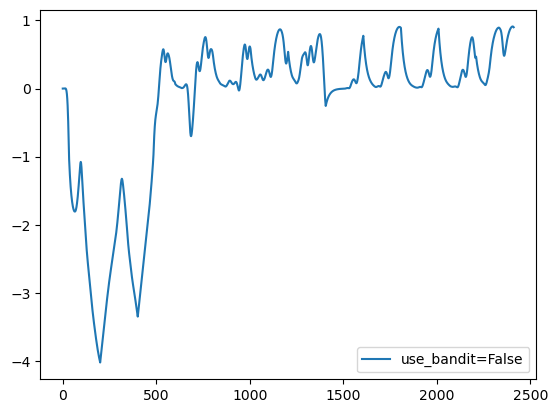

Experiment start! use_bandit = True
[Epoch 0] Got reward -1541.0515019238942
[Epoch 1] Got reward -442.97581865368846
[Epoch 2] Got reward 68.53347946685459
[Epoch 3] Got reward 70.28675971111724
[Epoch 4] Got reward 93.94467606183632
153.57461309432983 seconds
[4]
4.0
0.0
1005


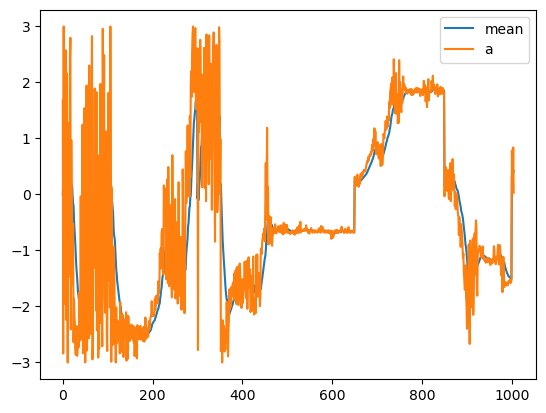

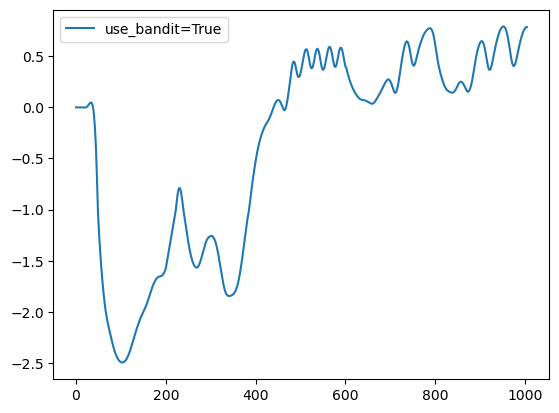

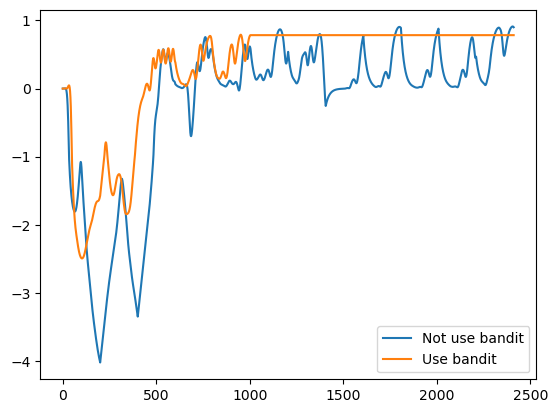

In [47]:
rub1, rub2, rub3, rub4 = whole_pipeline(39)